In [1]:
import numpy as np
import matplotlib.pyplot as plt

from wf_psf.sims.psf_simulator import PSFSimulator
from wf_psf.sims.spatial_varying_psf import SpatialVaryingPSF

/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'

# SED folder path
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_gt = np.load(data_dir + 'train_10000_stars_id_001_8bins.npy', allow_pickle=True)[()]

SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)[()]


In [3]:
n_zks_list = np.array([66, 45, 25, 15])
abs_err_lo = []
rel_err_lo = []
rel_std_lo = []
abs_err_hi = []
rel_err_hi = []
rel_std_hi = []


for n_zks in n_zks_list:
    dataset_approx_lo = np.load(data_dir + 'zks_low_order/train_10000_stars_id_001_8bins_{}zks_rms_{:.0e}.npy'.format(n_zks,5e-3), allow_pickle=True)[()]
    dataset_approx_hi = np.load(data_dir + 'zks_low_order/train_10000_stars_id_001_8bins_{}zks_rms_{:.0e}.npy'.format(n_zks,1e-2), allow_pickle=True)[()]
    
    # Dataset PSF error
    psf_error_list_lo = np.sum(np.array(dataset_gt['stars'][:dataset_approx_lo['parameters']['n_stars']]-dataset_approx_lo['stars'])**2, axis=(1,2))
    psf_rel_error_list_lo = psf_error_list_lo/np.sum(np.array(dataset_gt['stars'][:dataset_approx_lo['parameters']['n_stars']])**2, axis=(1,2))
    abs_err_lo.append(np.mean(psf_error_list_lo))
    rel_err_lo.append(np.mean(psf_rel_error_list_lo))
    rel_std_lo.append(np.std(psf_rel_error_list_lo))

    psf_error_list_hi = np.sum(np.array(dataset_gt['stars'][:dataset_approx_hi['parameters']['n_stars']]-dataset_approx_hi['stars'])**2, axis=(1,2))
    psf_rel_error_list_hi = psf_error_list_hi/np.sum(np.array(dataset_gt['stars'][:dataset_approx_hi['parameters']['n_stars']])**2, axis=(1,2))
    abs_err_hi.append(np.mean(psf_error_list_hi))
    rel_err_hi.append(np.mean(psf_rel_error_list_hi))
    rel_std_hi.append(np.std(psf_rel_error_list_hi))


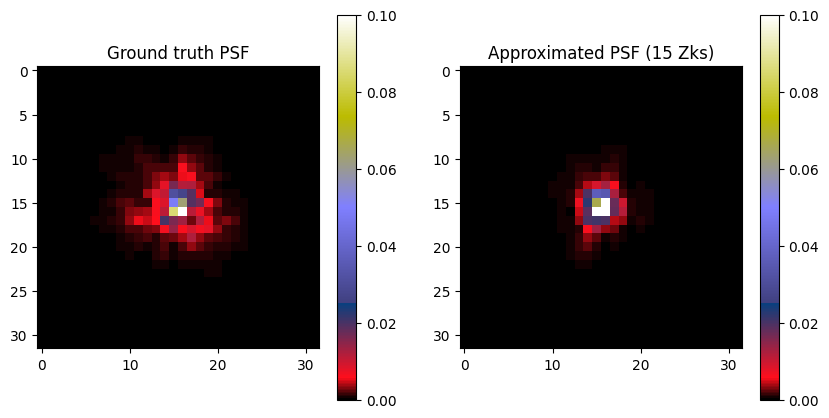

In [4]:
idx = np.random.randint(0, dataset_gt['parameters']['n_stars'])
fig, ax = plt.subplots(1,2, figsize=(10,5))
# Plot the PSFs in sharded colorbar
im = ax[0].imshow(np.array(dataset_gt['stars'][idx]), cmap='gist_stern', vmin=0, vmax=0.1)
fig.colorbar(im, ax=ax[0])
ax[0].set_title('Ground truth PSF')
im = ax[1].imshow(np.array(dataset_approx_lo['stars'][idx]), cmap='gist_stern', vmin=0, vmax=0.1)
fig.colorbar(im, ax=ax[1])
ax[1].set_title('Approximated PSF ({} Zks)'.format(n_zks))
plt.show()


In [5]:
idx

3322

7.054068334288585

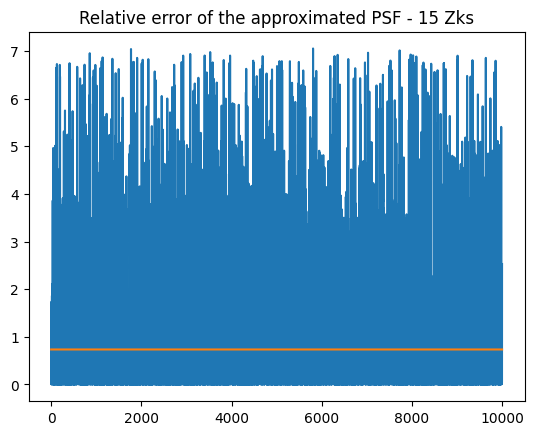

In [6]:
plt.plot(psf_rel_error_list_lo)
#plot the mean
plt.plot(np.mean(psf_rel_error_list_lo)*np.ones(len(psf_rel_error_list_lo)))
plt.title('Relative error of the approximated PSF - {} Zks'.format(n_zks))

psf_rel_error_list_lo[5808]


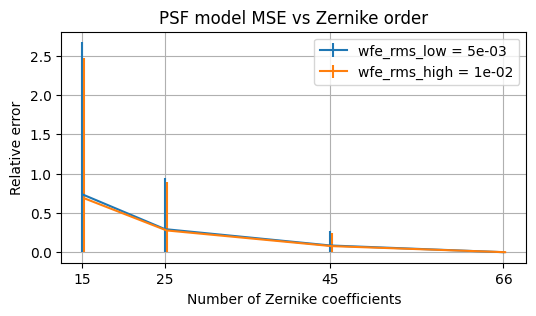

In [7]:
# Plot the dataset errors
plt.figure(figsize=(6, 3))
plt.errorbar(n_zks_list, rel_err_lo, yerr=[rel_err_lo,2*np.array(rel_std_lo)-np.array(rel_err_lo)] ,label='wfe_rms_low = {:.0e}'.format(dataset_approx_lo['parameters']['max_wfe_rms']))
plt.errorbar(np.array(n_zks_list)+0.2, rel_err_hi, yerr=[rel_err_hi,2*np.array(rel_std_hi)-np.array(rel_err_hi)] ,label='wfe_rms_high = {:.0e}'.format(dataset_approx_hi['parameters']['max_wfe_rms']))
plt.legend()
plt.xlabel('Number of Zernike coefficients')
plt.ylabel('Relative error')
plt.title('PSF model MSE vs Zernike order')
plt.xticks(n_zks_list)
plt.grid()
plt.show()



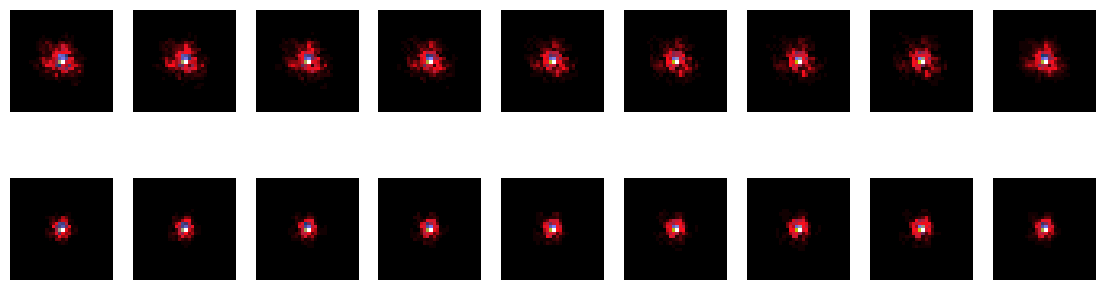

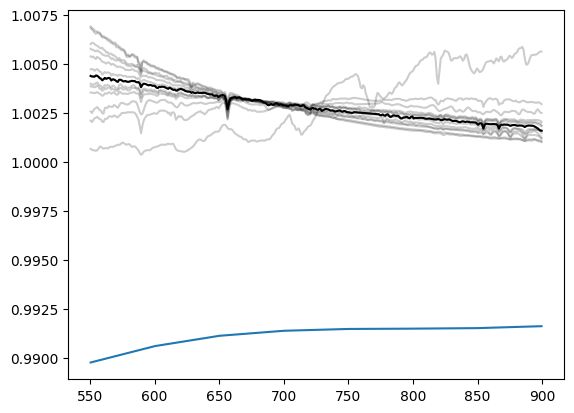

In [8]:
dataset_approx_hi = np.load(data_dir + 'zks_low_order/train_10000_stars_id_001_8bins_{}zks_rms_{:.0e}.npy'.format(25,1e-2), allow_pickle=True)[()]


# plot monoc psfs and the poly psf
im, ax = plt.subplots(2, dataset_gt['parameters']['n_bins']+1, figsize=(14, 4))

for i in range(dataset_gt['parameters']['n_bins']):
    ax[0][i].imshow(dataset_gt['mono_psfs'][idx,i], cmap='gist_stern')
    ax[0][i].axis('off')
for i in range(dataset_approx_hi['parameters']['n_bins']):
    ax[1][i].imshow(dataset_approx_hi['mono_psfs'][idx,i], cmap='gist_stern')
    ax[1][i].axis('off')

ax[0][-1].imshow(dataset_gt['stars'][idx], cmap='gist_stern')
ax[0][-1].axis('off')
ax[1][-1].imshow(dataset_approx_hi['stars'][idx], cmap='gist_stern')
ax[1][-1].axis('off')
plt.show()

# Plot the difference between the mono and poly psfs
lambdas = np.linspace(dataset_gt['SEDs'][idx][0,0], dataset_gt['SEDs'][idx][-1,0], dataset_gt['parameters']['n_bins'])
diff = np.array([np.sum((mono_psf-dataset_gt['stars'][idx])**2) for mono_psf in dataset_approx_hi['mono_psfs'][idx]])
plt.plot(lambdas,1-diff)
# Load and plot all the SEDs
SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)[()]
for sed in SEDs:
    plt.plot(dataset_gt['SEDs'][idx][:,0], 1+sed, 'k', alpha=0.2)
# Plot the SED
plt.plot(dataset_gt['SEDs'][idx][:,0], 1+dataset_gt['SEDs'][idx][:,1], 'k')

plt.show()

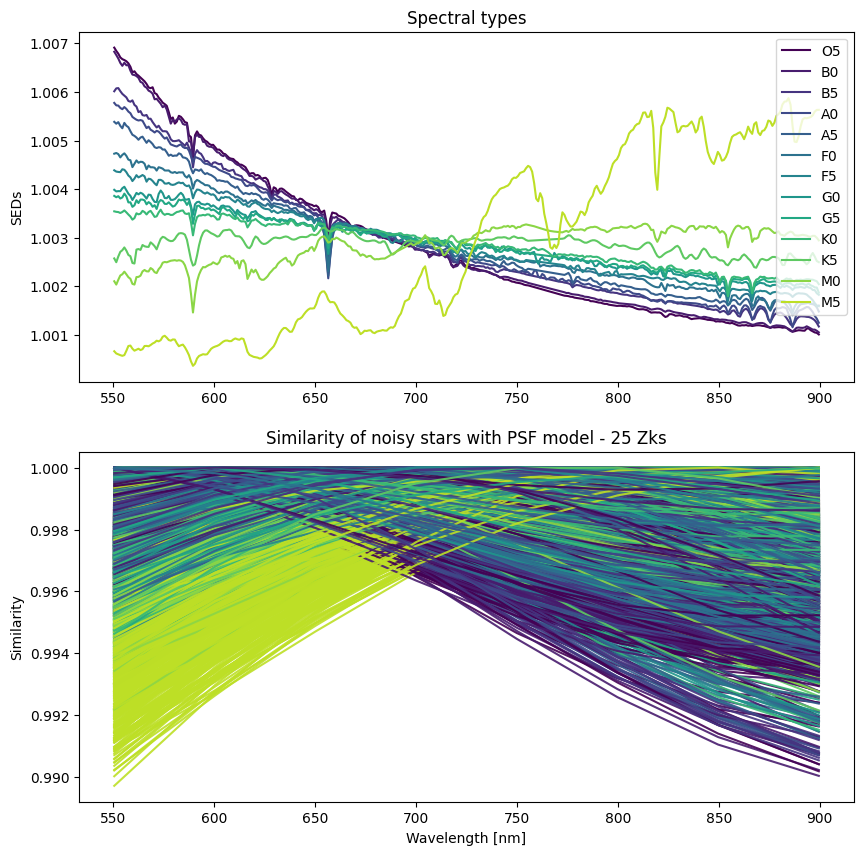

In [9]:
# Define 13 color palette
color_palette = plt.cm.viridis(np.linspace(0, 0.9, 13))
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

# Plot the difference with color code
fig, ax = plt.subplots(2,1,figsize=(10, 10))

# for i in range(dataset_approx['parameters']['n_stars']):
#     diff = np.array([np.sum((mono_psf-dataset_gt['stars'][i])**2) for mono_psf in dataset_approx['mono_psfs'][i]])
#     ax[0].plot(lambdas,1-diff, color=color_palette[dataset_gt['SED_ids'][i]], alpha=0.9)
# Plot the SEDs
for i in range(13):
    ax[0].plot(dataset_gt['SEDs'][0][:,0], 1+SEDs[i], color=color_palette[i], label=star_class_labels[i])
    ax[0].legend()

# # Plot similarity with the noisy stars
# for i in range(dataset_approx['parameters']['n_stars']):
#     diff = np.array([np.sum((mono_psf-dataset_gt['noisy_stars'][i])**2) for mono_psf in dataset_approx['mono_psfs'][i]])
#     ax[1].plot(lambdas,(1-diff), color=color_palette[dataset_gt['SED_ids'][i]], alpha=0.9)
# Plot normalised similarity with the noisy stars
for i in range(dataset_approx_hi['parameters']['n_stars']):
    diff = np.array([np.sum((mono_psf-dataset_gt['noisy_stars'][i])**2) for mono_psf in dataset_approx_hi['mono_psfs'][i]])
    ax[1].plot(lambdas,(1-diff)/np.max(1-diff), color=color_palette[dataset_gt['SED_ids'][i]], alpha=0.9)
ax[0].set_title('Spectral types')
ax[1].set_title('Similarity of noisy stars with PSF model - 25 Zks')
ax[0].set_ylabel('SEDs')
ax[1].set_ylabel('Similarity')
ax[1].set_xlabel('Wavelength [nm]')

plt.show()